In [34]:
import torch
print("CUDA?", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


CUDA? True
Tesla T4


In [36]:

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

IM_SIZE=224
train_dir="/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir ="/kaggle/input/intel-image-classification/seg_test/seg_test"

train_tfms=transforms.Compose([
    transforms.RandomResizedCrop(IM_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
valid_tfms=transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(IM_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

full_train=ImageFolder(train_dir, transform=train_tfms)
val_ratio=0.1
n_val=int(len(full_train)*val_ratio)
n_train=len(full_train)-n_val
train_ds, valid_ds = random_split(full_train, [n_train, n_val])
valid_ds.dataset.transform=valid_tfms

test_ds=ImageFolder(test_dir, transform=valid_tfms)
classes=full_train.classes   

BATCH=64
train_dl=DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True, persistent_workers=True)
valid_dl=DataLoader(valid_ds, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_dl =DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

print("Sınıflar:", classes)


Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [37]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.amp import autocast
import copy

NUM_CLASSES = len(classes)

# Model (ResNet18 + dropout)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.amp.GradScaler('cuda')

def run_epoch(dl, train=True):
    model.train() if train else model.eval()
    tot_loss=tot_ok=tot_n=0
    torch.set_grad_enabled(train)
    for x,y in dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        if train: optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            out = model(x); loss = criterion(out,y)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        pred = out.argmax(1)
        tot_ok += (pred==y).sum().item()
        tot_loss += loss.item()*y.size(0); tot_n += y.size(0)
    return tot_loss/tot_n, tot_ok/tot_n

# Eğitim
EPOCHS, patience = 8, 3
history={"tr_loss":[], "va_loss":[], "tr_acc":[], "va_acc":[]}
best_w,best_va=None,0.0
wait=0

for ep in range(1,EPOCHS+1):
    tr_loss,tr_acc=run_epoch(train_dl, True)
    va_loss,va_acc=run_epoch(valid_dl, False)
    sched.step()
    history["tr_loss"].append(tr_loss); history["va_loss"].append(va_loss)
    history["tr_acc"].append(tr_acc);   history["va_acc"].append(va_acc)
    print(f"Epoch {ep:02d} | tr_acc={tr_acc:.3f} va_acc={va_acc:.3f}")
    if va_acc>best_va:
        best_va, best_w, wait = va_acc, copy.deepcopy(model.state_dict()), 0
    else:
        wait+=1
        if wait>=patience:
            print("Early stopping."); break

if best_w: model.load_state_dict(best_w)
print("Best valid acc:", round(best_va,4))


Epoch 01 | tr_acc=0.893 va_acc=0.931
Epoch 02 | tr_acc=0.947 va_acc=0.927
Epoch 03 | tr_acc=0.968 va_acc=0.935
Epoch 04 | tr_acc=0.987 va_acc=0.944
Epoch 05 | tr_acc=0.997 va_acc=0.936
Epoch 06 | tr_acc=0.999 va_acc=0.946
Epoch 07 | tr_acc=0.999 va_acc=0.948
Epoch 08 | tr_acc=0.999 va_acc=0.944
Best valid acc: 0.948


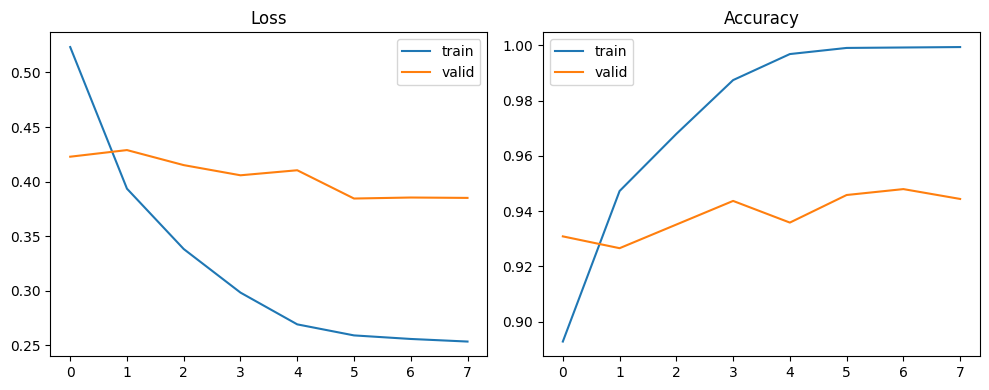

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["tr_loss"],label="train"); plt.plot(history["va_loss"],label="valid"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["tr_acc"],label="train"); plt.plot(history["va_acc"],label="valid"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()


              precision    recall  f1-score   support

   buildings       0.93      0.97      0.95       216
      forest       0.99      0.99      0.99       228
     glacier       0.91      0.92      0.91       241
    mountain       0.93      0.90      0.92       251
         sea       0.96      0.97      0.96       241
      street       0.98      0.95      0.96       226

    accuracy                           0.95      1403
   macro avg       0.95      0.95      0.95      1403
weighted avg       0.95      0.95      0.95      1403



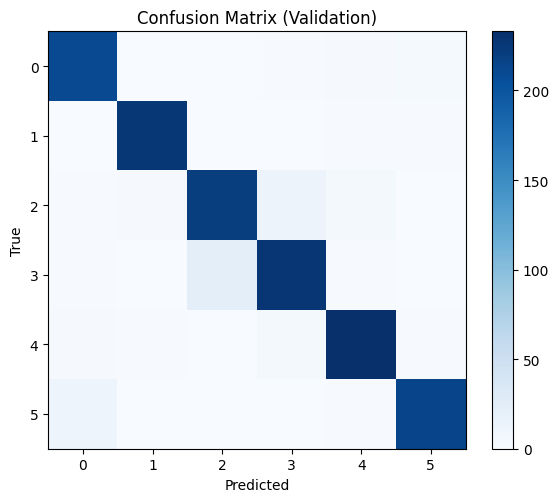

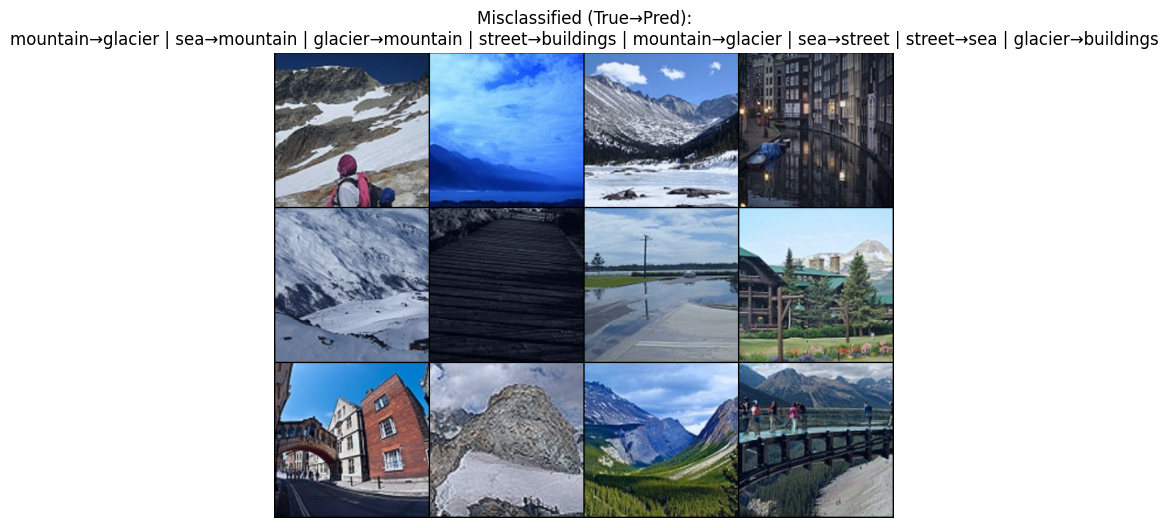

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np, matplotlib.pyplot as plt, torchvision, torch

model.eval(); y_true=[]; y_pred=[]
with torch.no_grad():
    for x,y in valid_dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        p = model(x).argmax(1)
        y_true += y.cpu().tolist()
        y_pred += p.cpu().tolist()

print(classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.tight_layout(); plt.show()

# Misclassified kolaj (ilk 12 örnek)
wrong_imgs, wrong_pairs = [], []
with torch.no_grad():
    for x,y in valid_dl:
        pr = model(x.to(DEVICE)).argmax(1).cpu()
        mask = pr != y
        if mask.any():
            wrong_imgs.append(x[mask])
            wrong_pairs += list(zip(y[mask].tolist(), pr[mask].tolist()))
        if len(wrong_pairs) >= 12: break

if wrong_imgs:
    grid = torchvision.utils.make_grid(torch.cat(wrong_imgs)[:12], nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8)); plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.axis("off")
    title = " | ".join(f"{classes[t]}→{classes[p]}" for t,p in wrong_pairs[:8])
    plt.title("Misclassified (True→Pred):\n"+title); plt.show()


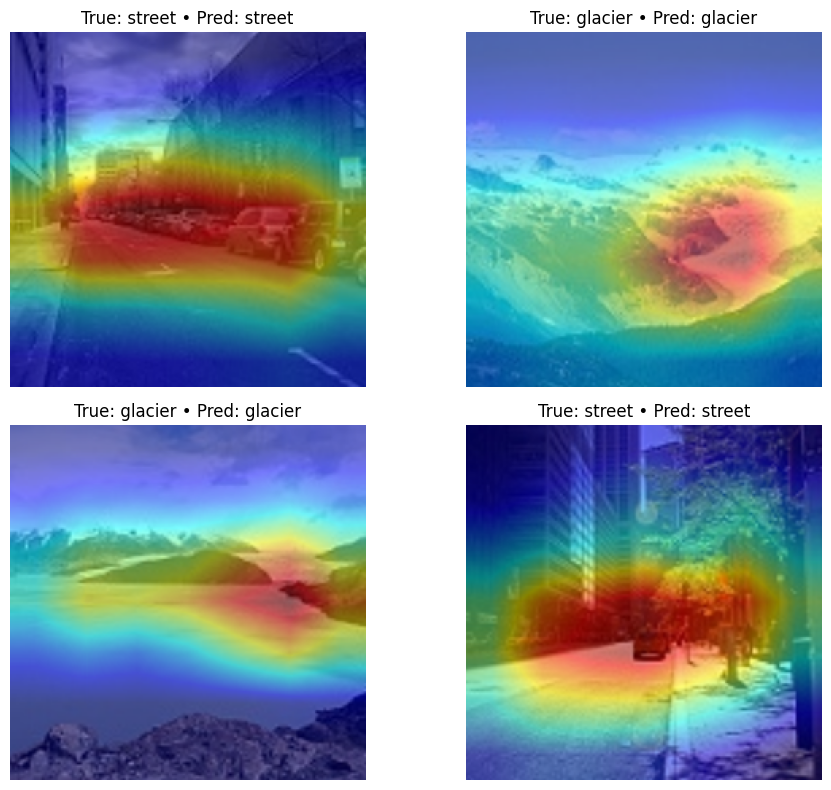

In [40]:
# ✅ Grad-CAM (enable_grad fix'i ile)
import torch, numpy as np, matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model.eval()
for p in model.parameters():
    p.requires_grad_(True)   # tüm katmanlarda grad açık

# valid'den küçük bir batch al
xb, yb = next(iter(valid_dl))
xb, yb = xb[:4], yb[:4]
input_tensor = xb.to(DEVICE).requires_grad_(True)

# hedef sınıfları belirle (tahmine göre)
with torch.no_grad():
    logits = model(input_tensor)
pred_idxs = logits.argmax(1).tolist()
targets = [ClassifierOutputTarget(c) for c in pred_idxs]

target_layer = model.layer4[-1]  # ResNet18 son blok
MEAN = np.array([0.485, 0.456, 0.406]); STD = np.array([0.229, 0.224, 0.225])
def denorm(img_t):
    x = img_t.detach().cpu().permute(1,2,0).numpy()
    x = x * STD + MEAN
    return np.clip(x, 0, 1).astype(np.float32)

with GradCAM(model=model, target_layers=[target_layer]) as cam:
    model.zero_grad(set_to_none=True)
    # 🔑 Grad açıkken CAM hesapla
    with torch.enable_grad():
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)  # (N,H,W)

plt.figure(figsize=(10,8))
for i in range(len(xb)):
    base = denorm(xb[i])
    cam_img = show_cam_on_image(base, grayscale_cam[i], use_rgb=True)
    plt.subplot(2,2,i+1); plt.imshow(cam_img); plt.axis("off")
    plt.title(f"True: {classes[yb[i].item()]} • Pred: {classes[pred_idxs[i]]}")
plt.tight_layout(); plt.show()


In [41]:
# ✅ Grad kesin açık + hızlı deneme için güvenli quick_eval
import torch, torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader

def quick_eval(lr, batch, drop, max_epochs=3, max_steps=150):
    tr_dl = DataLoader(train_ds, batch_size=batch, shuffle=True,
                       num_workers=4, pin_memory=True)
    va_dl = DataLoader(valid_ds,  batch_size=batch, shuffle=False,
                       num_workers=4, pin_memory=True)

    m = resnet18(weights=ResNet18_Weights.DEFAULT)
    m.fc = nn.Sequential(nn.Dropout(drop), nn.Linear(m.fc.in_features, len(classes)))
    m = m.to(DEVICE)

    # Her ihtimale karşı tüm parametrelerde grad açık
    for p in m.parameters(): p.requires_grad_(True)
    m.train()

    crit = nn.CrossEntropyLoss(label_smoothing=0.05)
    opt  = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=1e-4)
    sch  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_epochs)

    best = 0.0
    for _ in range(max_epochs):
        # ---- train (grad açık zorlaması) ----
        step = 0
        for x,y in tr_dl:
            x,y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with torch.enable_grad():           # 🔑 grad'ı zorunlu aç
                out  = m(x)
                loss = crit(out, y)
                loss.backward()
                opt.step()
            step += 1
            if max_steps and step >= max_steps:  # hızlı deneme için sınır
                break
        sch.step()

        # ---- valid ----
        m.eval()
        corr=cnt=0
        with torch.no_grad():
            for x,y in va_dl:
                x,y = x.to(DEVICE), y.to(DEVICE)
                pred = m(x).argmax(1)
                corr += (pred==y).sum().item(); cnt += y.size(0)
        best = max(best, corr/cnt)
        m.train()
    return best


In [ ]:
import pandas as pd
from itertools import product

grid = list(product([3e-4, 1e-4], [32, 64], [0.3, 0.5]))  # küçük ve hızlı
rows = []

print("Hiperparametre denemeleri başlıyor...")
for lr,b,dp in grid:
    acc = quick_eval(lr,b,dp, max_epochs=2, max_steps=100)  # daha da hızlı
    print(f"lr={lr}, batch={b}, drop={dp} -> val_acc={acc:.4f}")
    rows.append({"lr":lr, "batch":b, "dropout":dp, "val_acc":acc})

hp_df = pd.DataFrame(rows).sort_values("val_acc", ascending=False)
print("\n--- En iyi kombinasyon(lar) ---")
print(hp_df.head(3))


Hiperparametre denemeleri başlıyor...
lr=0.0003, batch=32, drop=0.3 -> val_acc=0.9202
lr=0.0003, batch=32, drop=0.5 -> val_acc=0.9330
lr=0.0003, batch=64, drop=0.3 -> val_acc=0.9244


Test Accuracy: 0.9343


,Metric,Value
0,Best Valid Acc,0.948
1,Test Acc,0.9343
2,Best HP,lr=0.0001 batch=32 dropout=0.5 (val=0.9423)


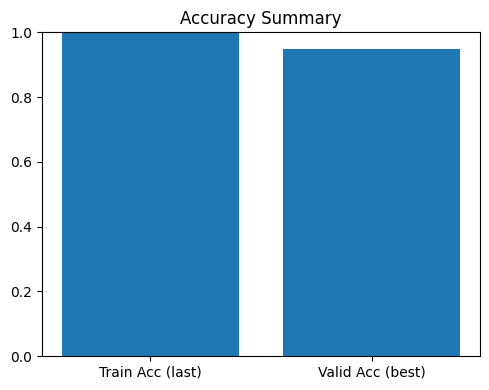

In [48]:
# --- Test Accuracy ---
model.eval(); corr=cnt=0
with torch.no_grad():
    for x,y in test_dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x).argmax(1)
        corr += (pred==y).sum().item()
        cnt  += y.size(0)
test_acc = corr / cnt
print("Test Accuracy:", round(test_acc, 4))

# --- Özet tablo ---
import pandas as pd, matplotlib.pyplot as plt
best_valid = max(history["va_acc"]) if "history" in globals() else None
if "hp_df" in globals() and len(hp_df)>0:
    best_hp = hp_df.iloc[0].to_dict()
    hp_text = f"lr={best_hp['lr']}  batch={int(best_hp['batch'])}  dropout={best_hp['dropout']} (val={best_hp['val_acc']:.4f})"
else:
    hp_text = "lr=3e-4  batch=64  dropout=0.3 (mini tarama yok)"

summary = pd.DataFrame([
    {"Metric":"Best Valid Acc", "Value": round(best_valid,4)},
    {"Metric":"Test Acc",       "Value": round(test_acc,4)},
    {"Metric":"Best HP",        "Value": hp_text}
])
display(summary)

# --- Accuracy mini bar chart ---
plt.figure(figsize=(5,4))
plt.bar(["Train Acc (last)", "Valid Acc (best)"], [history["tr_acc"][-1], best_valid])
plt.title("Accuracy Summary"); plt.ylim(0,1); plt.tight_layout(); plt.show()
